In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataloader import prepare_data_loader

import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        # self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        # self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=4)
        # self.bn3 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(63, hidden_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(hidden_size, 63)
        self.conv1 = nn.ConvTranspose2d(16, 8, kernel_size=4)
        self.conv2 = nn.ConvTranspose2d(8, 4, kernel_size=3)
        self.conv3 = nn.ConvTranspose2d(4, 1, kernel_size=3)

    def forward(self, x):
        x = self.fc(x)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def save_encoder(self, path):
        torch.save(self.encoder.state_dict(), path)

In [ ]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=training_data_dir,
                                  labels_file_path=training_labels_file)

In [5]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [6]:
autoencoder = ConvAutoencoder(hidden_size=20).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
num_epochs = 500
all_losses = []
autoencoder.train()
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.reshape(-1, 1, height, width).to(device)
        output = autoencoder(img)
        print(output.shape, img.shape)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item()}')
    all_losses.append(loss.item())

# autoencoder.save_encoder('./models/encoder.pth')
plt.plot(all_losses)
plt.yscale('log')
plt.show()

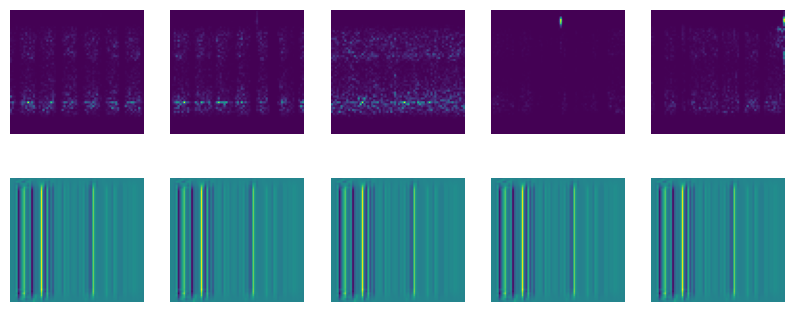

In [13]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    output = autoencoder(img)
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(img[i].cpu().numpy().squeeze())
        # print(img[i].cpu().numpy().squeeze())
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        # plt.imshow(output[i].cpu().numpy().squeeze())
        plt.imshow(np.ones(output[i].cpu().numpy().squeeze().shape)*0.5)
        # print('huy')
        # print(output[i].cpu().numpy().squeeze())
        plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    plt.imshow(img[0].cpu().numpy().squeeze())
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 4))
autoencoder.eval()
with torch.no_grad():
    img, _ = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    output = autoencoder(img)
    plt.imshow(output[0].cpu().numpy().squeeze())
    plt.axis('off')

In [ ]:
output[0]